# Compare linear parameter impact on Astar vs Dijkstra

In [1]:
import pandas as pd
import osmnx as ox
import networkx as nx
import time
import numpy as np

from geopy.distance import great_circle
import sys
sys.path.append('../../../Multimodal_freight_USA/')
from mfreight.Multimodal.graph_utils import MultimodalNet
from mfreight.utils import shortest_path_revisited

In [2]:
Net = MultimodalNet(path_u="../../../Multimodal_freight_USA/mfreight/Multimodal/data/multimodal_G_tot_u_w_price.plk")

# Compute Astar admissible heuristics

In [3]:
def heuristic_func_duration(u,v):
    G=Net.G_multimodal_u
    return great_circle((G.nodes[u]['y'],G.nodes[u]['x']),
                        (G.nodes[v]['y'],G.nodes[v]['x'])).miles / 75


def heuristic_func_co2(u,v):
    G=Net.G_multimodal_u
    return great_circle((G.nodes[u]['y'],G.nodes[u]['x']),
                       (G.nodes[v]['y'],G.nodes[v]['x'])).miles * 0.01213 #* 0.05001, 0.01213

def heuristic_func_price(u,v):
    G=Net.G_multimodal_u
    return great_circle((G.nodes[u]['y'],G.nodes[u]['x']),
                        (G.nodes[v]['y'],G.nodes[v]['x'])).miles * 0.757914 * 10000

# Compare algorithms
dijkstra vs Bidirectionnal dijkstra vs Astar

# Set medium haul route
This route has been chosen because it is not too close to any ocean border 

In [4]:
orig = (35.122246, -80.819619) # Charlotte
dest = (39.499301, -104.677064) # Denver

In [5]:
node_orig = ox.get_nearest_node(Net.G_reachable_nodes, orig, method="haversine", return_dist=False)
node_dest = ox.get_nearest_node(Net.G_reachable_nodes, dest, method="haversine", return_dist=False)

### Price

In [6]:
%%timeit
path_d_price = nx.dijkstra_path(G=Net.G_multimodal_u,
                              source=node_orig,
                              target=node_dest,
                              weight="('MA', 'CA')")

455 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
l, path_di_price = nx.bidirectional_dijkstra(G=Net.G_multimodal_u,
                                           source=node_orig,
                                           target=node_dest,
                                           weight="('MA', 'CA')")

340 ms ± 9.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
path_a_price = nx.astar_path(G=Net.G_multimodal_u,
                           source=node_orig,
                           target=node_dest,
                           weight="('MA', 'CA')",
                           heuristic=heuristic_func_price)

522 ms ± 4.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
path_d_price = nx.dijkstra_path(G=Net.G_multimodal_u,
                              source=node_orig,
                              target=node_dest,
                              weight="('MA', 'CA')")
l, path_di_price = nx.bidirectional_dijkstra(G=Net.G_multimodal_u,
                                           source=node_orig,
                                           target=node_dest,
                                           weight="('MA', 'CA')")
path_a_price = nx.astar_path(G=Net.G_multimodal_u,
                           source=node_orig,
                           target=node_dest,
                           weight="('MA', 'CA')",
                           heuristic=heuristic_func_price)

path_d_price == path_a_price == path_di_price

True

### Duration

In [10]:
%%timeit
path_d_duration = nx.dijkstra_path(G=Net.G_multimodal_u,
                              source=node_orig,
                              target=node_dest,
                              weight="duration_h")

431 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
l, path_di_duration = nx.bidirectional_dijkstra(G=Net.G_multimodal_u,
                                           source=node_orig,
                                           target=node_dest,
                                           weight="duration_h")

261 ms ± 5.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
path_a_duration = nx.astar_path(G=Net.G_multimodal_u,
                           source=node_orig,
                           target=node_dest,
                           weight="duration_h",
                           heuristic=heuristic_func_duration)

343 ms ± 9.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
path_d_duration = nx.dijkstra_path(G=Net.G_multimodal_u,
                              source=node_orig,
                              target=node_dest,
                              weight="duration_h")
l, path_di_duration = nx.bidirectional_dijkstra(G=Net.G_multimodal_u,
                                           source=node_orig,
                                           target=node_dest,
                                           weight="duration_h")
path_a_duration = nx.astar_path(G=Net.G_multimodal_u,
                           source=node_orig,
                           target=node_dest,
                           weight="duration_h",
                           heuristic=heuristic_func_duration)
path_d_duration == path_a_duration == path_di_duration

True

### Observations 


# Do test for multiple routes with multiple optimization criterias

In [14]:
departures={'Chicago':(41.763705, -87.714903),
            'Denver':(39.665040, -105.046780),
            'Dallas':(32.772557, -96.774195),
            'LA':(33.998788, -118.226320),
            'Charlotte':(35.122246, -80.819619),
            'Vegas':(36.097687, -115.201823),
            'Miami':(25.382380, -80.475159),
            'Seatle':(29.739678, -95.378221),
            }

arrivals={'Atlanta':(33.654622, -84.249274),
          'Phoenix':(33.438505, -112.075594),
          'Louisville':(38.246108, -85.744561),
          'Seatle':(47.612580, -122.312518),
          'Denver':(39.499301, -104.677064),
          'Nashville':(36.155835, -86.797575),
          'Dakota':(45.439440, -100.057166),
          'Houston':(47.612580, -122.312518)
          }

target_features=["duration_h", "CO2_eq_kg", "('MA', 'CA')"]
heuristics = [heuristic_func_duration, heuristic_func_co2, heuristic_func_price]

dists = [723,817,836,1140,1160,1563, 1793, 2140, 2300]

legends = [d + '->' + a + '\n' + str(dist) + 'miles' for d,a,dist in zip (departures, arrivals,dists)]

In [16]:
dijkstra_times=list()
astar_times=list()
bidijkstra_times=list()
control= list()
df = pd.DataFrame({})

for departure, arrival, legend in zip(departures, arrivals, legends):
    node_orig = ox.get_nearest_node(Net.G_reachable_nodes, departures[departure], method="haversine", return_dist=False)
    node_dest = ox.get_nearest_node(Net.G_reachable_nodes, arrivals[arrival], method="haversine", return_dist=False)
    for target_feature, heuristic in zip(target_features, heuristics):
        for i in range(6):
            start = time.time()
            path_d, d, rank_d = shortest_path_revisited.dijkstra(G=Net.G_multimodal_u,
                                  sources=[node_orig],
                                  target=node_dest,
                                  weight_str=target_feature,
                                  paths={node_orig:[node_orig]})

            df = df.append({'time [s]':time.time()-start,
                            'orig':departure, 'dest':arrival,
                            'algo':'Dijkstra',
                            'route':legend,
                            'target':target_feature,
                            '#n_explored': rank_d},
                           ignore_index=True)

            start = time.time()
            path_di, d, rank_di = shortest_path_revisited.bidirectionnal_dijkstra(G=Net.G_multimodal_u,
                                                       source=node_orig,
                                                       target=node_dest,
                                                       weight=target_feature)

            df = df.append({'time [s]':time.time()-start,
                            'orig':departure,
                            'dest':arrival,
                            'algo':'BiDijkstra',
                            'route':legend,
                            'target':target_feature,
                            '#n_explored': rank_di},
                           ignore_index=True)

            start = time.time()
            path_a, exp, counter = shortest_path_revisited.astar_path(G=Net.G_multimodal_u,
                                       source=node_orig,
                                       target=node_dest,
                                       weight=target_feature,
                                       heuristic=heuristic)
            
            df = df.append({'time [s]':time.time()-start,
                            'orig':departure,
                            'dest':arrival,
                            'algo':'Astar',
                            'route':legend,
                            'target':target_feature,
                            '#n_explored': counter},
                           ignore_index=True)
            control.append(path_a == path_di == path_d)

In [17]:
import numpy as np
np.sum(control) 

132

In [18]:
len(control)

144

The leg Denver -> Phoenix for the price target feature seems to yield different paths for the bidirectionnal dijkstra. After verification, this path gives teh same price for both paths. There are two possible optimal paths.

In [19]:
df1 = df.copy()
df1.reset_index(inplace=True)

<AxesSubplot:xlabel='index', ylabel='time [s]'>

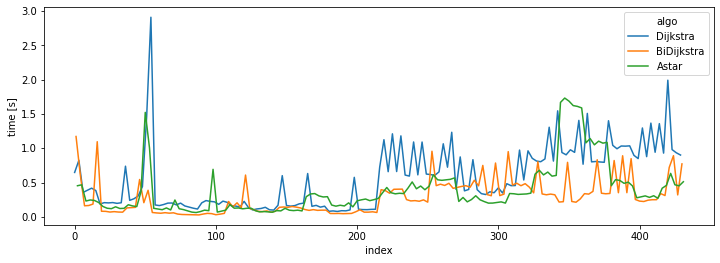

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(x='index',y='time [s]',hue='algo',data=df1)

In [21]:
df2 = df.copy()
df_grouped = df2.groupby(['orig','algo']).agg('median')

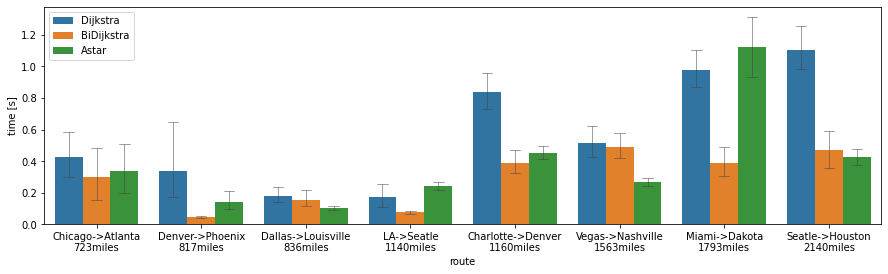

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 4))
g = sns.barplot(data=df2.reset_index(),x='route', y='time [s]',hue='algo', errwidth=0.5, capsize=.1)
g.legend(title=None)

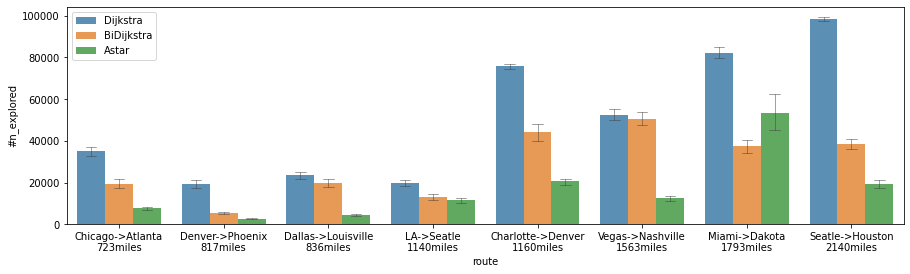

In [23]:
fig, ax = plt.subplots(figsize=(15, 4))
g = sns.barplot(x='route', y='#n_explored', hue='algo', data=df2.reset_index(),errwidth=0.5, capsize=.1, alpha=0.8)
g.legend(title=None)

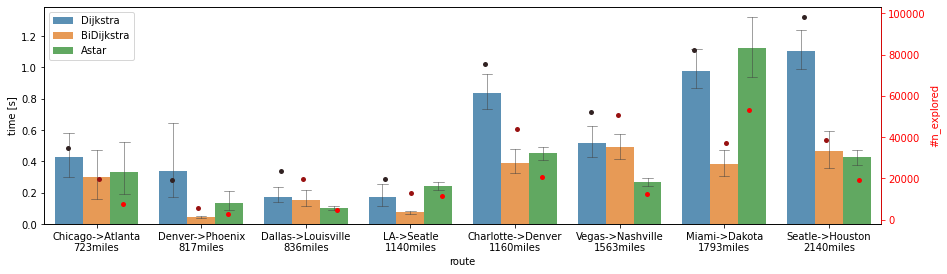

In [26]:
df3 = df2.groupby(['algo','route']).agg('mean').reset_index()
df3['dist'] = df3.route.str.extract(r'(\d+)').astype('int')
df3 = df3.sort_values(['dist','algo'],ascending=[True,False])
fig, ax = plt.subplots(figsize=(15, 4))
g = sns.barplot(x='route', y='time [s]', hue='algo', data=df2.reset_index(),errwidth=0.5, capsize=.1, alpha=0.8)
ax2 = ax.twinx()
g.legend(title=False)
g2 = sns.stripplot(data=df3,x='route', y='#n_explored',hue='algo', ax=ax2, dodge=True, color='red')
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')
g2.legend([],[], frameon=False)

In [27]:
df_grouped_w_target = df2.groupby(['orig','algo','target']).agg('median')
# df_grouped_w_target

<AxesSubplot:xlabel='route', ylabel='#n_explored'>

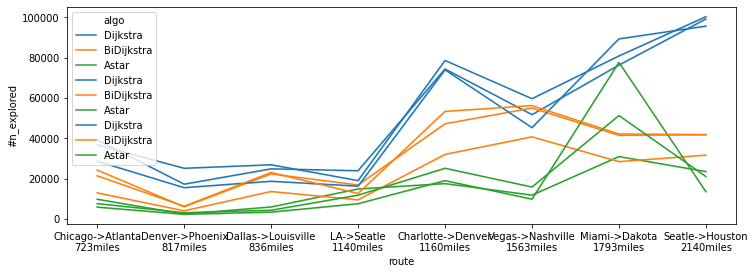

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))
dff = df2[df2.target == 'duration_h']
sns.lineplot(x='route', y='#n_explored', hue='algo', data=dff.reset_index())
dff2 = df2[df2.target == 'CO2_eq_kg']
sns.lineplot(x='route', y='#n_explored', hue='algo', data=dff2.reset_index())
dff3 = df2[df2.target == "('MA', 'CA')"]
sns.lineplot(x='route', y='#n_explored', hue='algo', data=dff3.reset_index())

<AxesSubplot:xlabel='route', ylabel='#n_explored'>

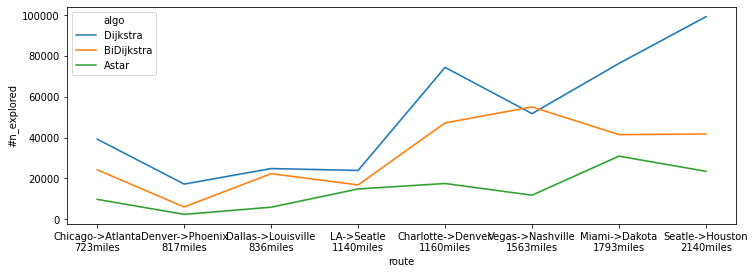

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
dff = df2[df2.target == 'duration_h']
sns.lineplot(x='route', y='#n_explored', hue='algo', data=dff.reset_index())

<AxesSubplot:xlabel='route', ylabel='#n_explored'>

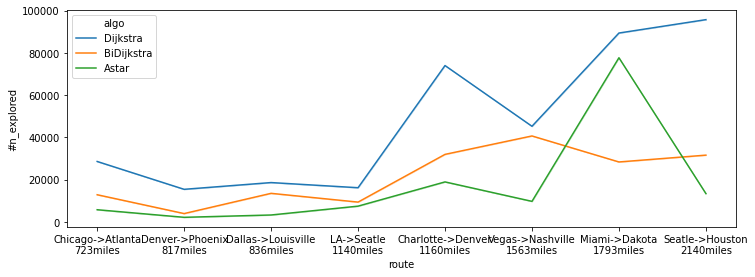

In [34]:
fig, ax = plt.subplots(figsize=(12, 4))
dff2 = df2[df2.target == 'CO2_eq_kg']
sns.lineplot(x='route', y='#n_explored', hue='algo', data=dff2.reset_index())

<AxesSubplot:xlabel='route', ylabel='#n_explored'>

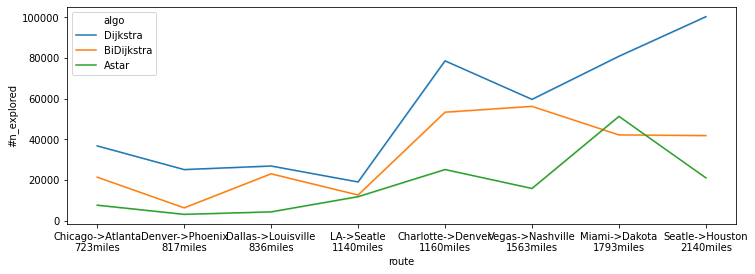

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))
dff3 = df2[df2.target == "('MA', 'CA')"]
sns.lineplot(x='route', y='#n_explored', hue='algo', data=dff3.reset_index())

In [ ]:
dff2 = df2[df2.target == 'CO2_eq_kg']
sns.lineplot(x='route', y='#n_explored', hue='algo', data=dff2.reset_index())

In [ ]:
stop

# Analyse loop response time A* vs Dijkstra

In [161]:
from heapq import heappop, heappush
from itertools import count
from typing import Callable, Tuple
from networkx.algorithms.shortest_paths.weighted import _weight_function


def astar_path_rev(G, source, target, heuristic=None, weight="weight", capture_list=[None]):

    if source not in G or target not in G:
        msg = f"Either source {source} or target {target} is not in G"
        raise nx.NodeNotFound(msg)

    if heuristic is None:
        # The default heuristic is h=0 - same as Dijkstra's algorithm
        def heuristic(u, v):
            return 0

    push = heappush
    pop = heappop
    weight = _weight_function(G, weight)

    # The queue stores heuristic, priority, node, cost to reach, and parent.
    # Uses Python heapq to keep in priority order.
    # Add a counter to the queue to prevent the underlying heap from
    # attempting to compare the nodes themselves. The hash breaks ties in the
    # priority and is guaranteed unique for all nodes in the graph.
    c = count()
    queue = [(0, next(c), source, 0, None)]

    # Maps enqueued nodes to distance of discovered paths and the
    # computed heuristics to target. We avoid computing the heuristics
    # more than once and inserting the node into the queue too many times.
    enqueued = {}
    # Maps explored nodes to parent closest to the source.
    explored = {}
    
    counter = 0
    timer=[]
    
    while queue:
        # Pop the smallest item from queue.
        _, rank, curnode, dist, parent = pop(queue)
        
        start = time.time()

        if curnode == target:
            path = [curnode]
            node = parent
            while node is not None:
                path.append(node)
                node = explored[node]
            path.reverse()
            return path, explored, timer, counter

        if curnode in explored:
            # Do not override the parent of starting node
            if explored[curnode] is None:
                continue

            # Skip bad paths that were enqueued before finding a better one
            qcost, h = enqueued[curnode]
            if qcost < dist:
                continue

        explored[curnode] = parent
        counter += 1

        for neighbor, w in G[curnode].items():
            ncost = dist + weight(curnode, neighbor, w)
            if neighbor in enqueued:
                qcost, h = enqueued[neighbor]
                # if qcost <= ncost, a less costly path from the
                # neighbor to the source was already determined.
                # Therefore, we won't attempt to push this neighbor
                # to the queue
                if qcost <= ncost:
                    continue
            else:
                h = heuristic(neighbor, target)
            enqueued[neighbor] = ncost, h
            push(queue, (ncost + h, next(c), neighbor, ncost, curnode))
        timer.append(time.time()-start)

    raise nx.NetworkXNoPath(f"Node {target} not reachable from {source}")

In [162]:
def weight(u, v, data):
    return lambda u, v, data: data.get(weight_str, 1)

def dijkstra_rev(
    G, source, weight_str, pred=None, paths=None, cutoff=None, target=None
):

    G_succ = G._succ if G.is_directed() else G._adj
    
    weight = lambda u, v, data: data.get(weight_str, 1)
    
    push = heappush
    pop = heappop
    dist = {}  # dictionary of final distances
    seen = {}
    # fringe is heapq with 3-tuples (distance,c,node)
    # use the count c to avoid comparing nodes (may not be able to)
    c = count()
    fringe = []
    timer=[]
    if source not in G:
        raise nx.NodeNotFound(f"Source {source} not in G")
        
    if target not in G:
        raise nx.NodeNotFound(f"Target {source} not in G")

    seen[source] = 0
    push(fringe, (0, next(c), source))
    while fringe:

        (d, rank, v) = pop(fringe)
        
        start = time.time()
        
        if v in dist:
            continue  # already searched this node.
            
        dist[v] = d
        if v == target:
            break
        for u, e in G_succ[v].items():
            cost = e.get(weight_str, 1)
            if cost is None:
                continue
            vu_dist = dist[v] + cost
            
            if cutoff is not None:
                if vu_dist > cutoff:
                    continue
            if u in dist:
                u_dist = dist[u]
                if vu_dist < u_dist:
                    raise ValueError("Contradictory paths found:", "negative weights?")
                elif pred is not None and vu_dist == u_dist:
                    pred[u].append(v)
            elif u not in seen or vu_dist < seen[u]:
                seen[u] = vu_dist
                push(fringe, (vu_dist, next(c), u))
                if paths is not None:
                    paths[u] = paths[v] + [u]
                if pred is not None:
                    pred[u] = [v]
            elif vu_dist == seen[u]:
                if pred is not None:
                    pred[u].append(v)
        timer.append(time.time()-start)

    # The optional predecessor and path dictionaries can be accessed
    # by the caller via the pred and paths objects passed as arguments.
    return dist, rank, timer

In [163]:
orig = (35.122246, -80.819619) # Charlotte
dest = (39.499301, -104.677064) # Denver

node_orig = ox.get_nearest_node(Net.G_reachable_nodes, orig, method="haversine", return_dist=False)
node_dest = ox.get_nearest_node(Net.G_reachable_nodes, dest, method="haversine", return_dist=False)

In [172]:
timer_list_A=[]
time_list_A=[]
for i in range(5):
    start = time.time()
    path_a_co2,ex,timer_A, counter = astar_path_rev(G=Net.G_multimodal_u,source=node_orig,target=node_dest,weight="CO2_eq_kg", heuristic=heuristic_func_co2)
    timer_list_A.append(timer_A)
    time_list_A.append(time.time()-start)

fastest_A = [idx for idx in range(len(time_list_A)) if min(time_list_A)==time_list_A[idx]]
timer_A = timer_list_A[fastest_A[0]]

In [182]:
%%timeit
heuristic_func_co2(node_orig,node_dest)

13.8 µs ± 81 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [181]:
nx.info(Net.G_multimodal_u)

'Name: \nType: Graph\nNumber of nodes: 90446\nNumber of edges: 133572\nAverage degree:   2.9536'

In [186]:
timer_list_D=[]
time_list_D=[]
for i in range(5):
    start = time.time()
    path = {node_orig:[node_orig]}
    dist, rank, timer_D = dijkstra_rev(G=Net.G_multimodal_u,
                                   source=node_orig, 
                                   target=node_dest, 
                                   weight_str="CO2_eq_kg",
                                   paths=path)
    timer_list_D.append(timer_D)
    time_list_D.append(time.time()-start)

fastest_D = [idx for idx in range(len(time_list_D)) if min(time_list_D)==time_list_D[idx]]
timer_D = timer_list_D[fastest_D[0]]

In [187]:
path_a_co2 == path[node_dest]

True

In [188]:
len(timer_A)

17109

In [189]:
len(timer_D)

64503

In [195]:
timer_A_s = pd.DataFrame({'Astar':timer_A,'Name':'Astar'})
timer_D_s = pd.DataFrame({'Dijkstra':timer_D})

df = pd.concat([timer_A_s,timer_D_s],axis=0,ignore_index=True)
df.Name.fillna('Dijkstra', inplace=True)
df.Astar.fillna(df.Dijkstra, inplace=True)
df= df.rename(columns={'Astar':'time [s]'}).drop(columns=['Dijkstra'])
df['time [ms]'] = df['time [s]']*1000000
df['y']='0'

In [196]:
np.mean(timer_A)

2.276376947987901e-05

In [197]:
np.mean(timer_D)

7.852784197857152e-06

In [213]:
np.mean(timer_A)/np.mean(timer_D)

2.898815108925409

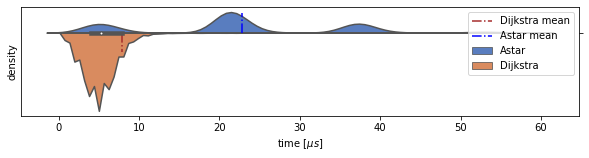

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,2))
plt.plot([np.mean(timer_D)*1000000]*2,[0,0.1],'-.', color='brown', label="Dijkstra mean")
ax = sns.violinplot(x='time [ms]',
                    y='y',
                    data=df[df['time [ms]']<60],
                    hue='Name',
                    split=True,
                    palette="muted",
                    scale='count')
ax.set(ylabel='density')
ax.set_xlabel(r'time $[\mu s]$')
ax.tick_params(left=False)
ax.set(yticklabels=[])
plt.plot([np.mean(timer_A)*1000000]*2,[0,-0.1],'-.', color='blue', label="Astar mean")

plt.legend(loc="upper right")